In [2]:
# KAN for Loan Status Prediction
# Based on https://www.kaggle.com/code/seyidcemkarakas/kan-tabular-data-binary-classification

import os
import pandas as pd
import json
import logging
import numpy as np
import torch
from torch import nn
from kan import KAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    f1_score,
    auc
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from utils.helper import (
    setup_logging,
    preprocess_combined_data,
    clean_feature_names
)

# Global variable for the target column
LABEL = "Loan Status"

def ks_score(true_labels, predicted_probabilities):
    """Calculate the KS score."""
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    return max(tpr - fpr)

def calculate_metrics(true_labels, predicted_probabilities, model_name, best_hyperparameters):
    """
    Calculate and return evaluation metrics for a model.
    Metrics include accuracy, ROC AUC, PR AUC, F1 score, KS score, and more.
    """
    predicted_labels = [1 if probability > 0.5 else 0 for probability in predicted_probabilities]
    
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities)
    pr_auc = auc(recall, precision)

    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'ROC_AUC': roc_auc_score(true_labels, predicted_probabilities),
        'PR_AUC': pr_auc,
        'F1_score': f1_score(true_labels, predicted_labels),
        'KS_score': ks_score(true_labels, predicted_probabilities),
        'num': len(true_labels),
        'best_hyperparameters': best_hyperparameters
    }
    return metrics

def get_training_results(results, logger):

    # Log training results
    logger.info(f"Training completed. Final train accuracy: {sum(results['train_acc'])/len(results['train_acc'])}, "
                f"validation accuracy: {sum(results['val_acc'])/len(results['val_acc'])}")
    
def test_model(model, test_input, test_label, hyperparameters, logger):

    # Make predictions on the test set
    logger.info("Making predictions with KAN model on test set")
    with torch.no_grad():
        test_outputs = model(test_input)
        # Get probabilities for the positive class (class 1)
        predicted_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

    # Calculate metrics
    metrics = calculate_metrics(
        true_labels=test_label, 
        predicted_probabilities=predicted_probabilities, 
        model_name="KAN", 
        best_hyperparameters=hyperparameters
    )
    logger.info(f"Metrics for KAN model: {metrics}")

    # Visualize ROC curve
    fpr, tpr, _ = roc_curve(test_label, predicted_probabilities)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {metrics["ROC_AUC"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


    # Display final metrics in a more readable format
    print("\nFinal Model Metrics:")
    metrics_df = pd.DataFrame([metrics]).drop('best_hyperparameters', axis=1).T
    display(metrics_df)

    # Display hyperparameters
    print("\nBest Hyperparameters:")
    for param, value in metrics['best_hyperparameters'].items():
        print(f"{param}: {value}")

In [3]:
# Setting up args and data
# Set up logging
setup_logging()
logger = logging
logger.info("Starting KAN Loan Prediction notebook")

# Set paths and parameters from the bash script
training_data_path = "datasets/prior/experts/train_expert.parquet"
testing_data_path = "datasets/prior/experts/test_expert_balanced.parquet"
metrics_output_dir = "results/expert_systems"
metrics_output_path = f"{metrics_output_dir}/kan_metrics.json"

# Set model parameters
encoding_threshold = 5
grid_size = 10
k_value = 3
optimizer = "LBFGS"
steps = 50
validation_split = 0.2
few_shot = None  # Not using few-shot learning by default

hyperparameters = {
    'grid_size': grid_size,
    'k': k_value,
    'optimizer': optimizer,
    'steps': steps,
    'validation_split': validation_split
}

# Load data
logger.info("Loading training and test datasets")
training_data = pd.read_parquet(training_data_path).dropna()
testing_data = pd.read_parquet(testing_data_path).dropna()

# Preprocess data together to ensure they have the same columns after encoding
training_data, testing_data = preprocess_combined_data(
    training_data, 
    testing_data, 
    threshold=encoding_threshold
)
training_data, testing_data = clean_feature_names(training_data, testing_data)

# Convert any boolean columns to integers (0 or 1)
for column in training_data.columns:
    if training_data[column].dtype == bool:
        training_data[column] = training_data[column].astype(int)
        testing_data[column] = testing_data[column].astype(int)
        
logger.info(f"Training dataset shape: {training_data.shape}")
logger.info(f"Test dataset shape: {testing_data.shape}")

# Define feature columns (excluding the target column)
feature_columns = [col for col in training_data.columns if col != LABEL]

2025-03-25 10:30:53,528 - INFO - Starting KAN Loan Prediction notebook
2025-03-25 10:30:53,529 - INFO - Loading training and test datasets
2025-03-25 10:30:53,607 - INFO - Training dataset shape: (8581, 28)
2025-03-25 10:30:53,608 - INFO - Test dataset shape: (1000, 28)


In [3]:
## Initialize model and dataset
device = torch.device("cpu")

# Define KAN model
model = KAN(width=[len(feature_columns), 2*len(feature_columns)+1, 4*len(feature_columns)+3, 2], grid=grid_size, k=k_value).to(device)

# Prepare feature inputs and target
X = training_data[feature_columns]
y = training_data[LABEL]

# Split training data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=validation_split, random_state=42
)

# Convert data to PyTorch tensors
train_input = torch.tensor(X_train.values, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train.values, dtype=torch.long).to(device)
val_input = torch.tensor(X_val.values, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val.values, dtype=torch.long).to(device)
test_input = torch.tensor(testing_data[feature_columns].values, dtype=torch.float32).to(device)
test_label = torch.tensor(testing_data[LABEL].values, dtype=torch.long).to(device)

# Train the model
dataset = {
    'train_input': train_input, 
    'train_label': train_label, 
    'test_input': val_input, 
    'test_label': val_label
}

# Plot the model before fitting
# model(dataset['train_input'])
# model.plot(scale=4.0)

checkpoint directory created: ./model
saving model version 0.0


In [4]:
logger.info(f"Training KAN model with grid={grid_size}, k={k_value}, optimizer={optimizer}, steps={steps}")

# Define accuracy metric functions for training
def train_acc():
    preds = torch.argmax(model(train_input), dim=1)
    return torch.mean((preds == train_label).float())

def val_acc():
    preds = torch.argmax(model(val_input), dim=1)
    return torch.mean((preds == val_label).float())

results = model.fit(
    dataset,
    metrics=(train_acc, val_acc),
    opt=optimizer,
    steps=steps,
    loss_fn=torch.nn.CrossEntropyLoss(),
    lamb=0.01,
    lamb_entropy=10.
)

get_training_results(results, logger)

2025-03-07 14:13:32,780 - INFO - Training KAN model with grid=10, k=3, optimizer=LBFGS, steps=50
| train_loss: 5.68e-01 | test_loss: 6.30e-01 | reg: 5.30e+02 | : 100%|█| 50/50 [12:18<00:00, 14.77s/
2025-03-07 14:25:51,748 - INFO - Training completed. Final train accuracy: 0.8325903260707855, validation accuracy: 0.8188351786136627


saving model version 0.1


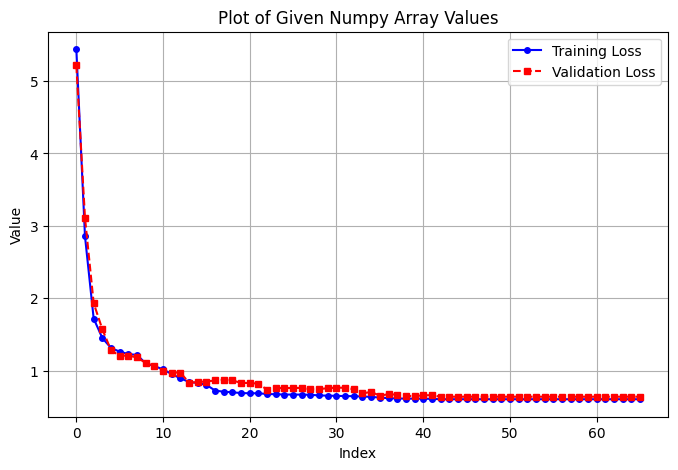

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(array_list1, array_list2):
    """
    Plots two curves from lists of numpy arrays containing single float values.
    
    Parameters:
    array_list1 (list): First list of numpy arrays with single float values.
    array_list2 (list): Second list of numpy arrays with single float values.
    """
    # Convert lists of numpy arrays to 1D numpy arrays
    values1 = np.array([arr.item() for arr in array_list1])
    values2 = np.array([arr.item() for arr in array_list2])
    
    # Create index arrays
    indices1 = np.arange(len(values1))
    indices2 = np.arange(len(values2))
    
    # Plot the curves
    plt.figure(figsize=(8, 5))
    plt.plot(indices1, values1, marker='o', linestyle='-', markersize=4, label='Training Loss', color='b')
    plt.plot(indices2, values2, marker='s', linestyle='--', markersize=4, label='Validation Loss', color='r')
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.title("Plot of Losses")
    plt.legend()
    plt.grid()
    plt.show()
    
plot_curves(results["train_loss"], results["test_loss"])

2025-03-07 10:29:48,634 - INFO - Making predictions with KAN model on test set
2025-03-07 10:29:48,769 - INFO - Metrics for KAN model: {'model': 'KAN', 'accuracy': 0.698, 'ROC_AUC': 0.8732387860677335, 'PR_AUC': 0.7949954733669609, 'F1_score': 0.5918918918918918, 'KS_score': 0.6601921470342522, 'num': 1000, 'best_hyperparameters': {'grid_size': 10, 'k': 3, 'optimizer': 'LBFGS', 'steps': 66, 'validation_split': 0.2}}


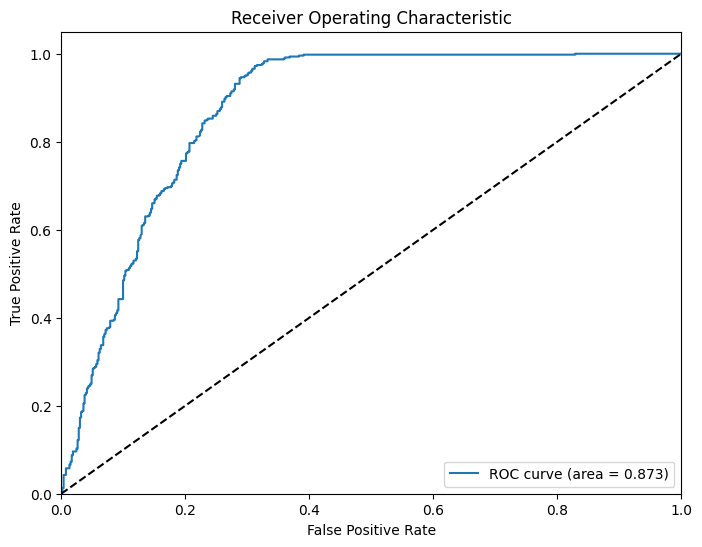


Final Model Metrics:


,0
model,KAN
accuracy,0.698
ROC_AUC,0.873239
PR_AUC,0.794995
F1_score,0.591892
KS_score,0.660192
num,1000



Best Hyperparameters:
grid_size: 10
k: 3
optimizer: LBFGS
steps: 66
validation_split: 0.2


In [19]:
test_model(model, test_input, test_label, hyperparameters, logger)

saving model version 0.2


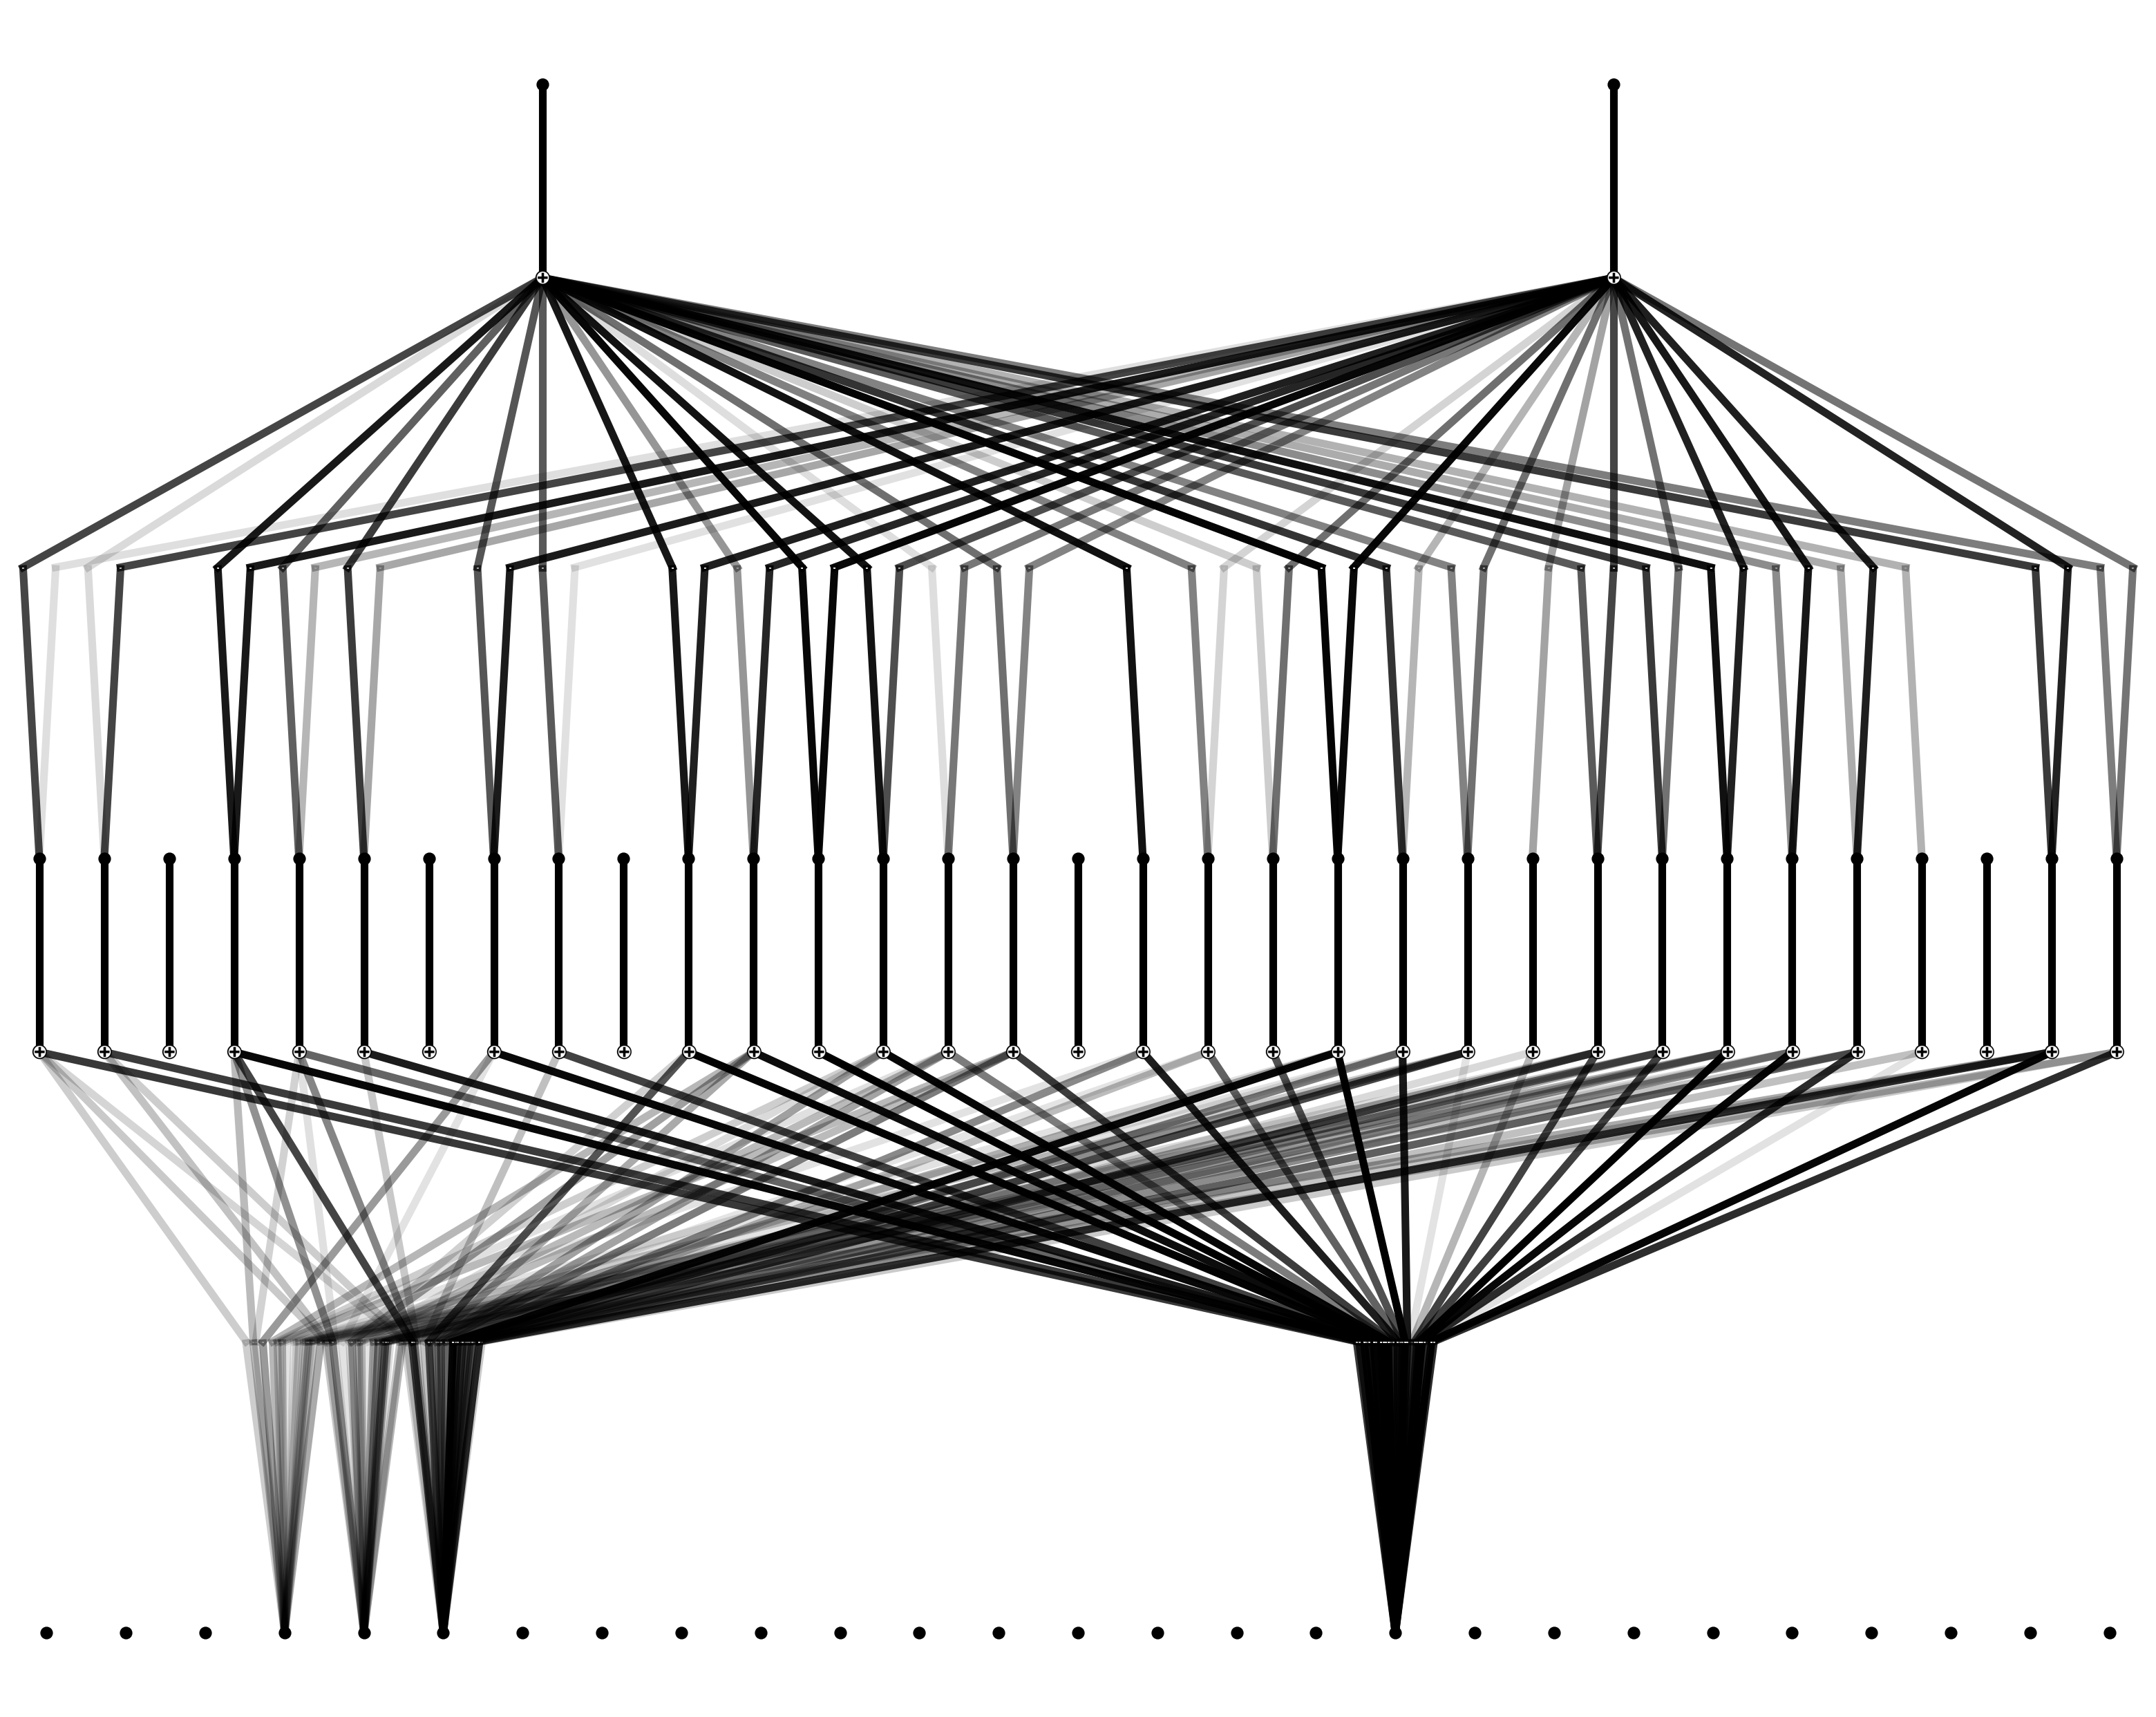

In [20]:
model = model.prune()
model(dataset['train_input'])
model.plot(scale=4.0)

In [ ]:
training_data.columns[[3,4,5,17]]

Index(['Last Payment Amount', 'Loan Amount', 'Revolving Balance',
       'Annual Income'],
      dtype='object')

Exception ignored in atexit callback: <bound method InteractiveShell.atexit_operations of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f30c137ded0>>
Traceback (most recent call last):
  File "/home/brain/anaconda3/envs/reasoning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3765, in atexit_operations
    self._atexit_once()
  File "/home/brain/anaconda3/envs/reasoning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3748, in _atexit_once
    self.history_manager.end_session()
  File "/home/brain/anaconda3/envs/reasoning/lib/python3.10/site-packages/IPython/core/history.py", line 602, in end_session
    self.writeout_cache()
  File "/home/brain/anaconda3/envs/reasoning/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/home/brain/anaconda3/envs/reasoning/lib/python3.10/site-packages/IPython/core/history.py", line 60, in only_when_enabled
    return f(self, *a, **kw)
  Fi

In [22]:
results_pruned = model.fit(
    dataset,
    metrics=(train_acc, val_acc),
    opt=optimizer,
    steps=steps,
    loss_fn=torch.nn.CrossEntropyLoss(),
)

get_training_results(results_pruned, logger)

| train_loss: 5.90e-01 | test_loss: 6.08e-01 | reg: 2.45e+01 | : 100%|█| 66/66 [00:23<00:00,  2.82it
2025-03-07 10:46:20,649 - INFO - Training completed. Final train accuracy: 0.8221153616905212, validation accuracy: 0.80780428647995


saving model version 0.3


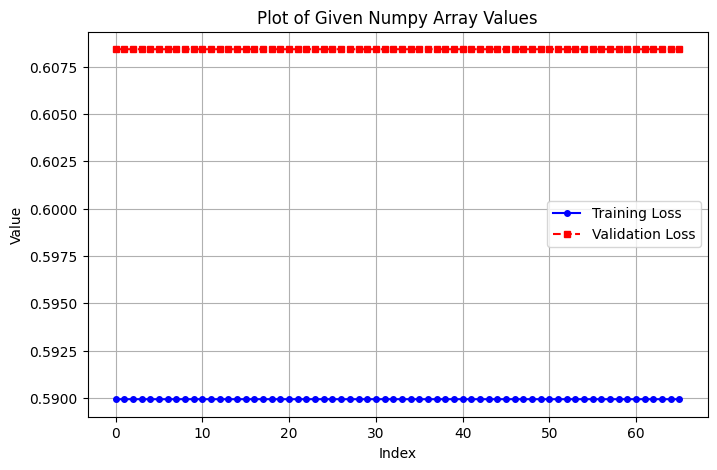

In [25]:
plot_curves(results_pruned["train_loss"], results_pruned["test_loss"])

2025-03-07 10:46:43,940 - INFO - Making predictions with KAN model on test set
2025-03-07 10:46:43,966 - INFO - Metrics for KAN model: {'model': 'KAN', 'accuracy': 0.711, 'ROC_AUC': 0.8767792879634985, 'PR_AUC': 0.7784149102872271, 'F1_score': 0.6131191432396251, 'KS_score': 0.6980431848852902, 'num': 1000, 'best_hyperparameters': {'grid_size': 10, 'k': 3, 'optimizer': 'LBFGS', 'steps': 66, 'validation_split': 0.2}}


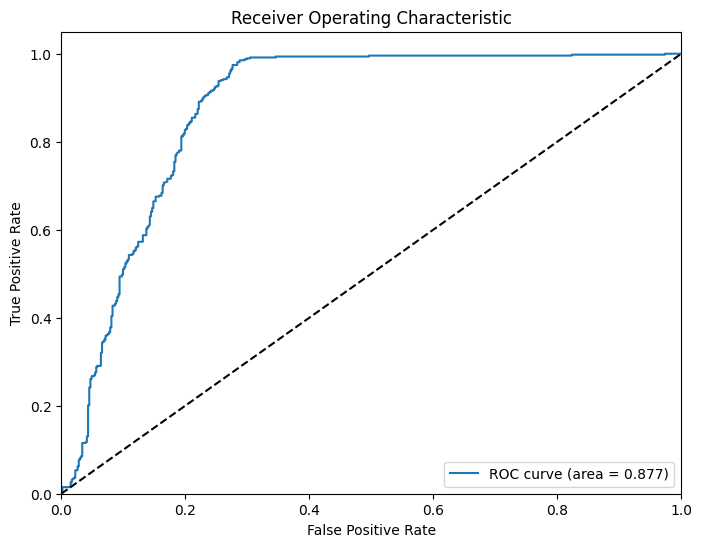


Final Model Metrics:


,0
model,KAN
accuracy,0.711
ROC_AUC,0.876779
PR_AUC,0.778415
F1_score,0.613119
KS_score,0.698043
num,1000



Best Hyperparameters:
grid_size: 10
k: 3
optimizer: LBFGS
steps: 66
validation_split: 0.2


In [23]:
test_model(model, test_input, test_label, hyperparameters, logger)

In [26]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with 0
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,0,6) with 0
fixing (0,0,7) with 0
fixing (0,0,8) with 0
fixing (0,0,9) with 0
fixing (0,0,10) with 0
fixing (0,0,11) with 0
fixing (0,0,12) with 0
fixing (0,0,13) with 0
fixing (0,0,14) with 0
fixing (0,0,15) with 0
fixing (0,0,16) with 0
fixing (0,0,17) with 0
fixing (0,0,18) with 0
fixing (0,0,19) with 0
fixing (0,0,20) with 0
fixing (0,0,21) with 0
fixing (0,0,22) with 0
fixing (0,0,23) with 0
fixing (0,0,24) with 0
fixing (0,0,25) with 0
fixing (0,0,26) with 0
fixing (0,0,27) with 0
fixing (0,0,28) with 0
fixing (0,0,29) with 0
fixing (0,0,30) with 0
fixing (0,0,31) with 0
fixing (0,0,32) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with 0
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,1,6) with 0
fixing (0,1,7) with 0
fixing (0,1,8) with 0
fixing (0,1,9) with 0
fixing (0,1,10) with 0
fixing (

In [29]:
model.symbolic_formula()[0][0]

-0.0087789628478145*x_18 + 0.0344137512555548*x_4 - 0.0305853772849818*x_5 + 0.0399900136189348*x_6 - 24.8587134350762

In [30]:
model.symbolic_formula()[0][1]

-0.00878674720617836*x_18 + 0.0328222819630609*x_4 - 0.0304362617744168*x_5 + 0.0399738445820447*x_6 - 25.473533387505